In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
def plot_rolling_statistics(timeseries,window=12):
    rolmean=timeseries.rolling(window=window).mean()
    rolstd=timeseries.rolling(window=window).std()
    
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    dftest=adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

dataset_filepath=os.getenv('HOME')+'/aiffel/stock_prediction/data/AAPL.csv'
df=pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True)
ts=df['Close']
ts.head()

Date
2021-09-29    142.830002
2021-09-30    141.500000
2021-10-01    142.649994
2021-10-04    139.139999
2021-10-05    141.110001
Name: Close, dtype: float64

In [4]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [5]:
ts_log=np.log(ts)

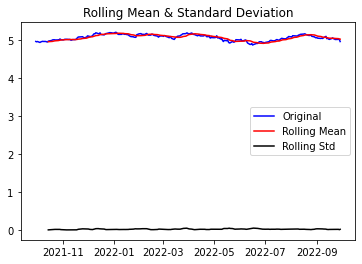

Results of Dickey-Fuller Test:
Test Statistic                  -2.026070
p-value                          0.275260
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


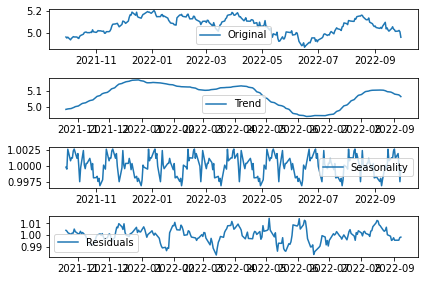

In [12]:
plot_rolling_statistics(ts_log,window =12)

augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative',period=30)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.plot(ts_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.017071
p-value                          0.000021
#Lags Used                      11.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


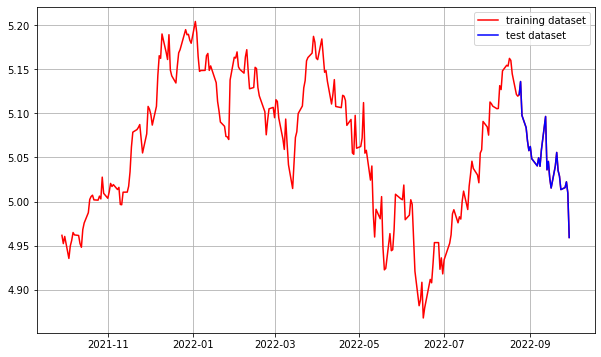

In [14]:
train_data, test_data=ts_log[:int(len(ts_log)*0.9)],ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r',label='training dataset')
plt.plot(test_data,c='b',label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


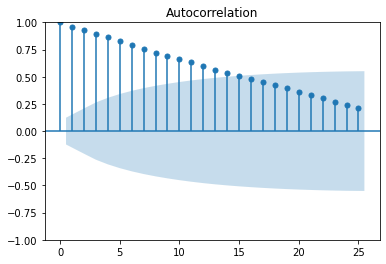

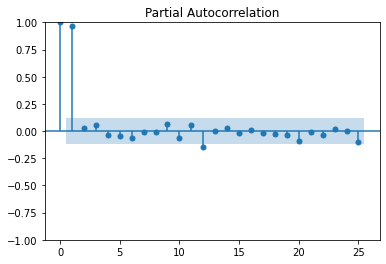

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.579095e+01
p-value                        1.102389e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.047325e+00
p-value                        4.946247e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


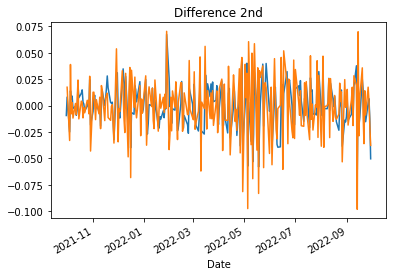

In [19]:
diff_1=ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

diff_2=diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

In [21]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(train_data, order=(2,0,1))
fitted_m=model.fit()

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 570.586
Date:                Fri, 30 Sep 2022   AIC                          -1131.171
Time:                        03:03:05   BIC                          -1114.047
Sample:                             0   HQIC                         -1124.261
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0490      0.321     15.747      0.000       4.421       5.677
ar.L1          0.1284      0.055      2.331      0.020       0.020       0.236
ar.L2          0.8637      0.056     15.406      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


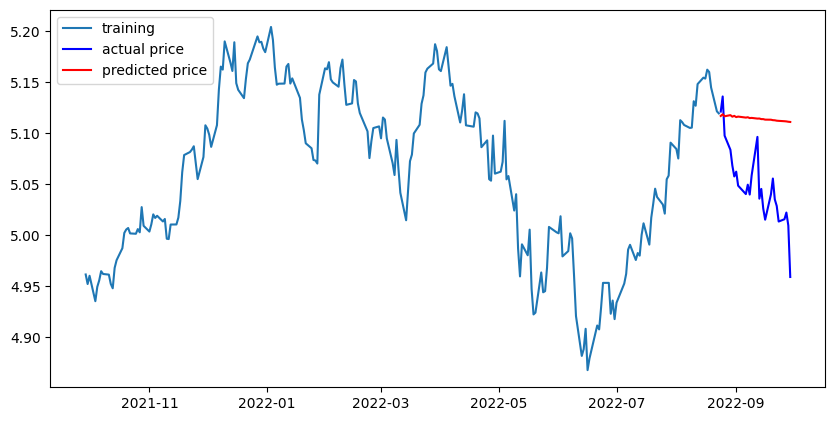

In [23]:
fc=fitted_m.forecast(len(test_data),alpha=0.5)
fc=np.array(fc)

fc_series=pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10,5),dpi=100)
plt.plot(train_data,label='training')
plt.plot(test_data,c='b',label='actual price')
plt.plot(fc_series,c='r',label='predicted price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse=mean_squared_error(np.exp(test_data),np.exp(fc))
print('MSE: ',mse)

mae=mean_absolute_error(np.exp(test_data),np.exp(fc))
print('MAE: ',mae)

rmse=mse**0.5
print('RMSE: ',rmse)

mape=np.mean(np.abs(np.exp(fc)-np.exp(test_data))/np.abs(np.exp(test_data)))
print("MAPE: {:.2f}%".format(mape*100))

MSE:  139.79067330856267
MAE:  10.771965195221698
RMSE:  11.823310590040451
MAPE: 7.03%
